In [ ]:
# Cell 1: Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from matplotlib.patches import Patch

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Cell 2: Load FC and PPI data
# Define paths - modify these to match your environment
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
output_dir = f'{results_dir}/connectivity_comparison'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# File paths for FC and PPI data
fc_csv_path = f'{output_dir}/bilateral_fc_connectivity_fingerprint_results.csv'
ppi_csv_path = f'{output_dir}/bilateral_ppi_connectivity_fingerprint_results.csv'

# Path to merged atlas labels
merged_labels_file = f'{results_dir}/merged_atlas_labels.npy'

In [3]:
# Cell 3: Define Helper Functions for ROI Classification
def map_to_anatomical_lobe(roi_name):
    """Map ROI names to anatomical lobes"""
    # Convert bytes to string if needed
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    # Special handling for Wang atlas ROIs
    if 'Wang_pIPS' in roi_name:
        return 'Parietal'
    elif 'Wang_LO' in roi_name:
        return 'Temporal'
    
    # Map Schaefer networks to anatomical regions
    if 'Vis' in roi_name:
        return 'Occipital'
    elif 'SomMot' in roi_name:
        return 'Somatomotor'
    elif 'DorsAttn' in roi_name:
        if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name or 'MT' in roi_name:
            return 'Temporal'
        else:
            return 'Parietal'
    elif 'SalVentAttn' in roi_name:
        if 'Ins' in roi_name:
            return 'Insular'
        elif 'Cing' in roi_name or 'ACC' in roi_name:
            return 'Cingulate'
        elif 'Temp' in roi_name:
            return 'Temporal'
        elif 'Par' in roi_name:
            return 'Parietal'
        else:
            return 'Frontal'
    elif 'Limbic' in roi_name:
        if 'Temp' in roi_name:
            return 'Temporal'
        else:
            return 'Frontal'
    elif 'Cont' in roi_name:
        if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name or 'MT' in roi_name:
            return 'Temporal'
        elif 'Cing' in roi_name:
            return 'Cingulate'
        else:
            return 'Frontal'
    elif 'Default' in roi_name:
        if 'Par' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name:
            return 'Temporal'
        elif 'PCC' in roi_name or 'Cing' in roi_name:
            return 'Cingulate'
        else:
            return 'Frontal'
    else:
        return 'Other'

def clean_roi_name(roi_name):
    """Clean up ROI names for better labeling"""
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    # Handle Wang ROIs
    if 'Wang_' in roi_name:
        return roi_name.replace('Wang_', '')
    
    # Remove common prefixes and suffixes
    cleaned = roi_name.replace('7Networks_', '')
    
    # Extract just the region part, removing hemisphere and network
    parts = cleaned.split('_')
    if len(parts) > 2:
        return parts[-2] + '_' + parts[-1]
    elif len(parts) > 1:
        return parts[-1]
    else:
        return cleaned

def get_hemisphere_and_region(roi_name):
    """Determine hemisphere and base region for organizing pairs"""
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    # Determine hemisphere 
    if 'LH' in roi_name:
        hemisphere = 'L'
    elif 'RH' in roi_name:
        hemisphere = 'R'
    else:
        # For Wang ROIs or ROIs without clear hemisphere
        if 'Wang_pIPS' in roi_name or 'Wang_LO' in roi_name:
            hemisphere = 'X'  # Bilateral
        else:
            hemisphere = 'X'  # Unknown
    
    # Extract base region by removing hemisphere and number
    cleaned = roi_name.replace('7Networks_', '')
    cleaned = cleaned.replace('LH_', '').replace('RH_', '')
    
    # Handle Wang ROIs
    if 'Wang_' in cleaned:
        base_region = cleaned.replace('Wang_', '')
    else:
        # Remove trailing numbers which often differentiate regions
        base_region = re.sub(r'_\d+$', '', cleaned)
    
    return hemisphere, base_region

In [29]:
# Cell 4: Main Visualization Function
def visualize_anatomical_organization(results_df, roi_data, analysis_type='fc'):
    """Create anatomical organization visualization with:
    - Lobes ordered posterior to anterior
    - Lobe labels at the bottom of panel one
    - No x-axis numbers
    - Only label positive max (pIPS-preferring) and negative min (LO-preferring) ROIs
    """
    print(f"\nCreating {analysis_type.upper()} anatomical organization visualization...")
    
    # Extract data from parameters
    mean_pips = roi_data['mean_pips']
    mean_lo = roi_data['mean_lo']
    diff_profile = roi_data['diff_profile']
    ci_lower = roi_data['ci_lower']
    ci_upper = roi_data['ci_upper']
    sig_combined = roi_data['sig_combined']
    
    # Add anatomical lobe and hemisphere information to the dataframe
    results_df['Anatomical_Lobe'] = results_df['ROI_Name'].apply(map_to_anatomical_lobe)
    results_df['Clean_Name'] = results_df['ROI_Name'].apply(clean_roi_name)
    
    # Extract hemisphere and base region info
    hemisphere_region = results_df['ROI_Name'].apply(get_hemisphere_and_region)
    results_df['Hemisphere'] = [h for h, r in hemisphere_region]
    results_df['Base_Region'] = [r for h, r in hemisphere_region]
    
    # Define a manual order for anatomical lobes - posterior to anterior
    lobe_order = [
        'Occipital',
        'Temporal',
        'Parietal',
        'Insular',
        'Cingulate',
        'Somatomotor',
        'Frontal',
        'Other'
    ]
    
    # Create a category for sorting based on the defined order
    lobe_cat = pd.Categorical(results_df['Anatomical_Lobe'], categories=lobe_order, ordered=True)
    results_df['Lobe_Sorted'] = lobe_cat
    
    # Define a consistent color palette for brain lobes
    lobe_colors = {
        'Frontal': '#3498db',     # Blue
        'Somatomotor': '#f1c40f', # Yellow
        'Parietal': '#e74c3c',    # Red
        'Temporal': '#2ecc71',    # Green
        'Occipital': '#9b59b6',   # Purple
        'Insular': '#f39c12',     # Orange
        'Cingulate': '#1abc9c',   # Turquoise
        'Other': '#7f8c8d'        # Gray
    }
    
    # Custom sorting function to group by lobe, then by base region, then by hemisphere (L then R)
    def custom_sort(row):
        lobe_idx = lobe_order.index(row['Anatomical_Lobe']) if row['Anatomical_Lobe'] in lobe_order else 999
        hemi_idx = 0 if row['Hemisphere'] == 'L' else 1 if row['Hemisphere'] == 'R' else 2
        return (lobe_idx, row['Base_Region'], hemi_idx)
    
    # Sort using the custom function
    results_df['sort_key'] = results_df.apply(custom_sort, axis=1)
    results_df_sorted = results_df.sort_values('sort_key')
    
    # Get the new order
    sorted_indices = results_df_sorted.index.values
    
    # Extract reordered data
    mean_pips_sorted = results_df_sorted['pIPS_Connectivity'].values
    mean_lo_sorted = results_df_sorted['LO_Connectivity'].values
    diff_profile_sorted = results_df_sorted['Difference'].values
    sig_sorted = results_df_sorted['Combined_Significant'].values
    
    # IMPROVED APPROACH: Find extreme ROIs in each lobe
    significant_roi_positions = []
    lobe_sections = []
    
    # First identify sections for each lobe
    current_lobe = None
    start_idx = 0
    
    for i, idx in enumerate(sorted_indices):
        lobe = results_df_sorted.iloc[i]['Anatomical_Lobe']
        if lobe != current_lobe:
            if current_lobe is not None:
                # Store the section boundaries
                lobe_sections.append((current_lobe, start_idx, i-1))
            current_lobe = lobe
            start_idx = i
    
    # Add the last section
    if current_lobe is not None:
        lobe_sections.append((current_lobe, start_idx, len(sorted_indices)-1))
    
    # Now find max and min in each section
    for lobe, start, end in lobe_sections:
        # Get just the data for this lobe
        section_indices = sorted_indices[start:end+1]
        section_diff = diff_profile_sorted[start:end+1]
        section_sig = sig_sorted[start:end+1]
        
        # Filter to significant only
        sig_positions = np.where(section_sig)[0]
        
        if len(sig_positions) > 0:
            # Get significant values only
            sig_diffs = section_diff[sig_positions]
            
            # FIXED: Only label positive max and negative min
            # Find position of maximum (pIPS > LO) if positive
            if np.max(sig_diffs) > 0:
                max_sig_idx = sig_positions[np.argmax(sig_diffs)]
                significant_roi_positions.append(start + max_sig_idx)
            
            # Find position of minimum (LO > pIPS) if negative
            if np.min(sig_diffs) < 0:
                min_sig_idx = sig_positions[np.argmin(sig_diffs)]
                significant_roi_positions.append(start + min_sig_idx)
    
    # Create the visualization
    plt.figure(figsize=(18, 10))
    
    # Top subplot - connectivity profiles with lollipop plot, organized by lobe
    ax1 = plt.subplot(2, 1, 1)
    x = np.arange(len(mean_pips_sorted))
    
    # Get the y-limits for label positioning
    y_min, y_max = min(min(mean_pips_sorted), min(mean_lo_sorted)), max(max(mean_pips_sorted), max(mean_lo_sorted))
    y_range = y_max - y_min
    
    # Plot background colors for different lobes
    for lobe, start, end in lobe_sections:
        # Add background color
        plt.axvspan(start - 0.5, end + 0.5, alpha=0.15, color=lobe_colors[lobe])
        
        # Add label at the bottom
        label_y = y_min - 0.1 * y_range
        plt.text((start + end) / 2, label_y, lobe, ha='center', fontsize=11, fontweight='bold')
    
    # Create lollipop plot - vertical lines connecting pIPS and LO points
    for i in range(len(x)):
        plt.plot([x[i], x[i]], [mean_pips_sorted[i], mean_lo_sorted[i]], color='gray', linestyle='-', linewidth=0.5)
    
    # Plot the points
    plt.scatter(x, mean_pips_sorted, color='#4ac0c0', s=20, label='pIPS')
    plt.scatter(x, mean_lo_sorted, color='#ff9b83', s=20, label='LO')
    
    # Set y-axis limits with padding for the labels
    plt.ylim(y_min - 0.2 * y_range, y_max + 0.1 * y_range)
    
    # Remove x-axis tick labels from top panel
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    
    plt.ylabel('Connectivity Strength')
    plt.title(f'{analysis_type.upper()} ROI Connectivity Profiles (Organized by Anatomical Regions, L-R Pairs)')
    plt.legend(loc='upper left')
    plt.xlim(-0.5, len(mean_pips_sorted) - 0.5)
    
    # Bottom subplot - difference
    ax2 = plt.subplot(2, 1, 2)
    
    # Create base bar plot for all bars
    base_colors = ['#4ac0c0' if val > 0 else '#ff9b83' for val in diff_profile_sorted]
    bars = plt.bar(x, diff_profile_sorted, color=base_colors)
    
    # Apply transparency to non-significant bars individually
    for i, (bar, is_sig) in enumerate(zip(bars, sig_sorted)):
        if not is_sig:
            # Set alpha for non-significant bars only
            bar.set_alpha(0.3)
    
    plt.axhline(y=0, color='black', linestyle='-')
    
    # Add a legend for significance
    legend_elements = [
        Patch(facecolor='gray', alpha=1.0, label='Significant'),
        Patch(facecolor='gray', alpha=0.3, label='Non-significant')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Add background colors for different lobes (same as top plot)
    for lobe, start, end in lobe_sections:
        plt.axvspan(start - 0.5, end + 0.5, alpha=0.15, color=lobe_colors[lobe])
    
    # Remove x-axis tick labels from bottom panel too
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    
    # Label only significant peak and bottom ROIs
    for position in significant_roi_positions:
        # Get information for this position in the sorted array
        orig_idx = sorted_indices[position]
        roi_name = results_df.loc[orig_idx, 'Clean_Name']
        diff_value = diff_profile_sorted[position]
        
        # Add annotation - without ROI number
        plt.annotate(f'{roi_name}',
                    xy=(position, diff_value),
                    xytext=(0, 20 if diff_value >= 0 else -25),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if diff_value >= 0 else 'top',
                    fontsize=8,
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', lw=1.5))
    
    plt.ylabel('pIPS - LO Difference')
    plt.xlabel('ROI ID (Organized by Anatomical Region, L-R Pairs)')
    plt.title(f'{analysis_type.upper()} Connectivity Difference (Transparent bars = non-significant)')
    plt.xlim(-0.5, len(mean_pips_sorted) - 0.5)
    
    # Set different y-axis limits for the second panel based on analysis type
    if analysis_type == 'fc':
        # For FC analysis: range from -0.2 to 0.2
        plt.ylim(-0.2, 0.2)
    else:  # For PPI analysis
        # For PPI analysis: range from -0.05 to 0.05
        plt.ylim(-0.05, 0.05)
    
    plt.tight_layout()
    
    # Save the figure
    fig_path = f'{output_dir}/{analysis_type}_anatomical_organization.png'
    plt.savefig(fig_path, dpi=300)
    plt.show()
    
    print(f"Figure saved to {fig_path}")
    
    # Print peak and bottom ROIs by lobe, only for significant ROIs
    print(f"\n{analysis_type.upper()} significant peak and bottom ROIs by anatomical lobe:")
    
    for lobe, start, end in lobe_sections:
        # Get the data for this lobe
        section_indices = sorted_indices[start:end+1]
        section_df = results_df.loc[section_indices]
        
        # Get significant ROIs in this lobe
        sig_group = section_df[section_df['Combined_Significant']]
        
        if len(sig_group) > 0:
            print(f"\n{lobe} Lobe:")
            
            # Find most positive (pIPS-preferring) significant ROI
            pips_group = sig_group[sig_group['Difference'] > 0]
            if len(pips_group) > 0:
                peak_row = pips_group.loc[pips_group['Difference'].idxmax()]
                print(f"  Peak (pIPS > LO): {peak_row['Clean_Name']}, " + 
                      f"Diff = {peak_row['Difference']:.3f}")
            else:
                print("  No significant pIPS-preferring ROIs in this lobe")
            
            # Find most negative (LO-preferring) significant ROI
            lo_group = sig_group[sig_group['Difference'] < 0]
            if len(lo_group) > 0:
                bottom_row = lo_group.loc[lo_group['Difference'].idxmin()]
                print(f"  Bottom (LO > pIPS): {bottom_row['Clean_Name']}, " + 
                      f"Diff = {bottom_row['Difference']:.3f}")
            else:
                print("  No significant LO-preferring ROIs in this lobe")

In [17]:
# Cell 5: Load Data and Prepare ROI Data for Visualization
def load_data_for_visualization(analysis_type='fc'):
    """Load data from CSV and prepare it for visualization
    
    Parameters:
    -----------
    analysis_type : str
        Type of analysis, either 'fc' or 'ppi'
        
    Returns:
    --------
    tuple
        (results_df, roi_data) for visualization
    """
    csv_path = f'{output_dir}/bilateral_{analysis_type}_connectivity_fingerprint_results.csv'
    
    if not os.path.exists(csv_path):
        print(f"Error: {analysis_type.upper()} results file not found at {csv_path}")
        return None, None
        
    # Load results
    results_df = pd.read_csv(csv_path)
    print(f"Loaded {analysis_type.upper()} data with {len(results_df)} ROIs")
    
    # Prepare ROI data for visualization
    roi_data = {
        'mean_pips': results_df['pIPS_Connectivity'].values,
        'mean_lo': results_df['LO_Connectivity'].values,
        'diff_profile': results_df['Difference'].values,
        'ci_lower': results_df['CI_Lower'].values,
        'ci_upper': results_df['CI_Upper'].values,
        'sig_combined': results_df['Combined_Significant'].values
    }
    
    return results_df, roi_data

Loaded FC data with 200 ROIs

Creating FC anatomical organization visualization...


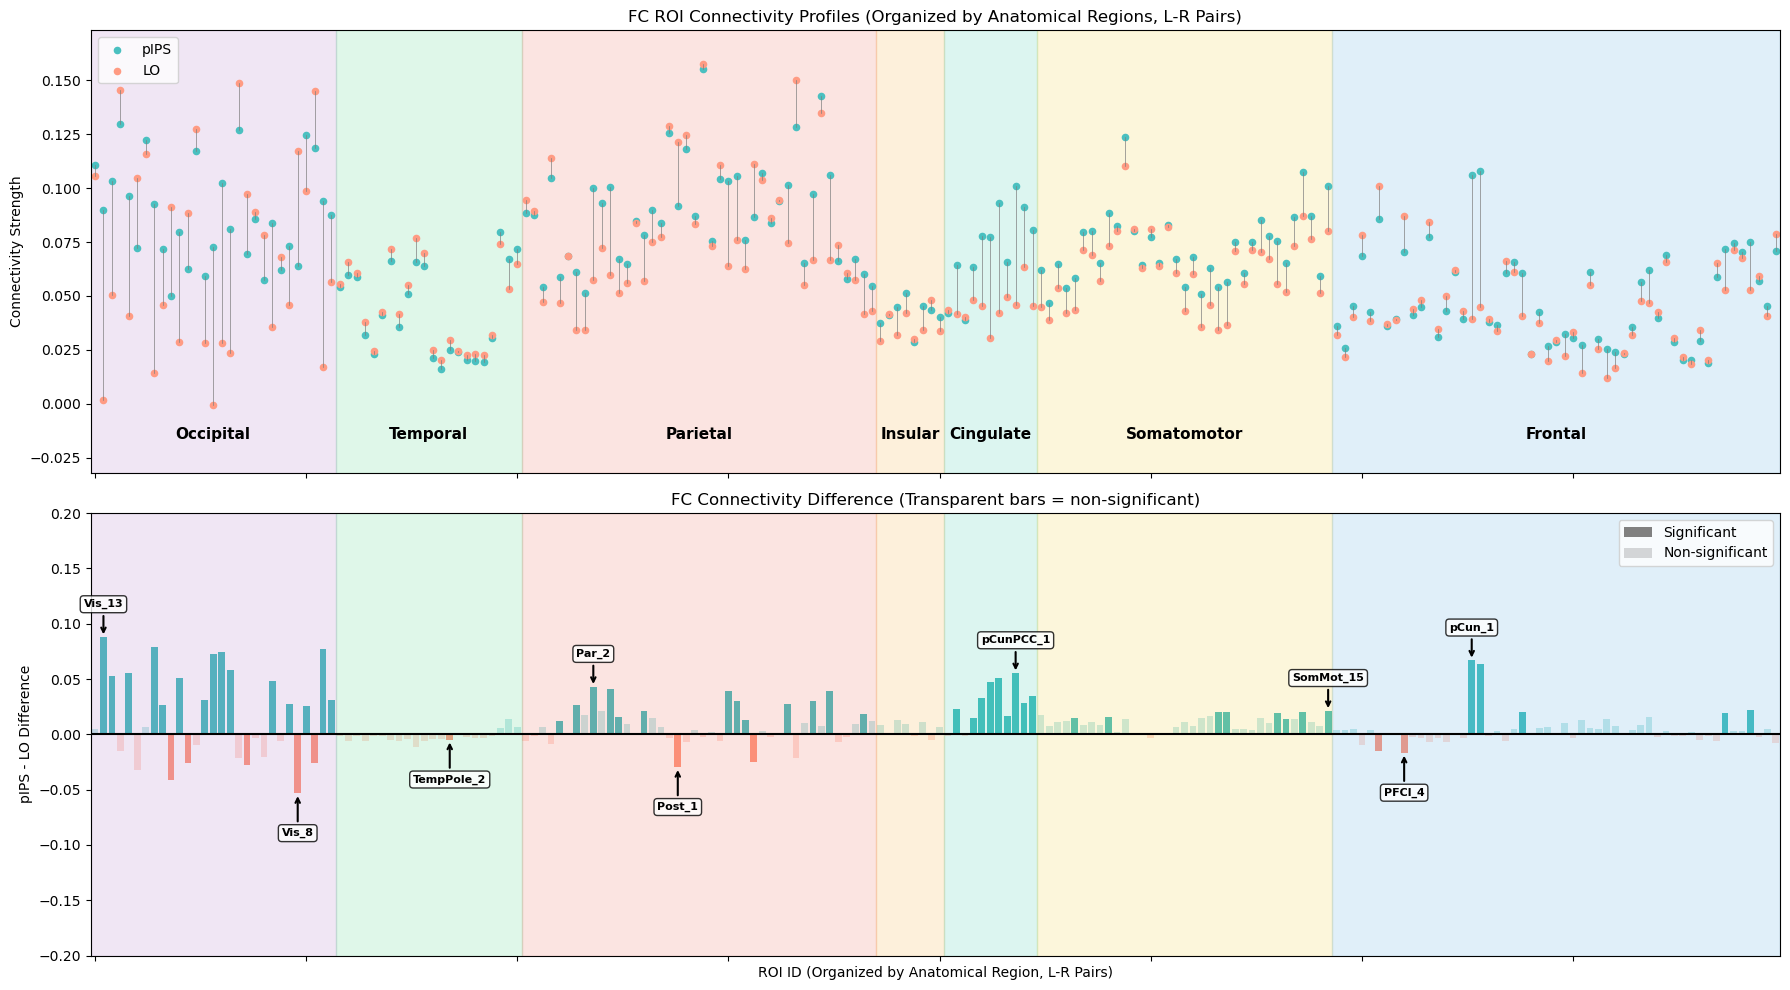

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_comparison/fc_anatomical_organization.png

FC significant peak and bottom ROIs by anatomical lobe:

Occipital Lobe:
  Peak (pIPS > LO): Vis_13, Diff = 0.088
  Bottom (LO > pIPS): Vis_8, Diff = -0.053

Temporal Lobe:
  No significant pIPS-preferring ROIs in this lobe
  Bottom (LO > pIPS): TempPole_2, Diff = -0.005

Parietal Lobe:
  Peak (pIPS > LO): Par_2, Diff = 0.043
  Bottom (LO > pIPS): Post_1, Diff = -0.030

Cingulate Lobe:
  Peak (pIPS > LO): pCunPCC_1, Diff = 0.055
  No significant LO-preferring ROIs in this lobe

Somatomotor Lobe:
  Peak (pIPS > LO): SomMot_15, Diff = 0.021
  No significant LO-preferring ROIs in this lobe

Frontal Lobe:
  Peak (pIPS > LO): pCun_1, Diff = 0.067
  Bottom (LO > pIPS): PFCl_4, Diff = -0.017


In [30]:
# Cell 6: Create FC Visualization
# Load and visualize FC data
fc_results, fc_data = load_data_for_visualization('fc')
if fc_results is not None and fc_data is not None:
    visualize_anatomical_organization(fc_results, fc_data, analysis_type='fc')

Loaded PPI data with 200 ROIs

Creating PPI anatomical organization visualization...


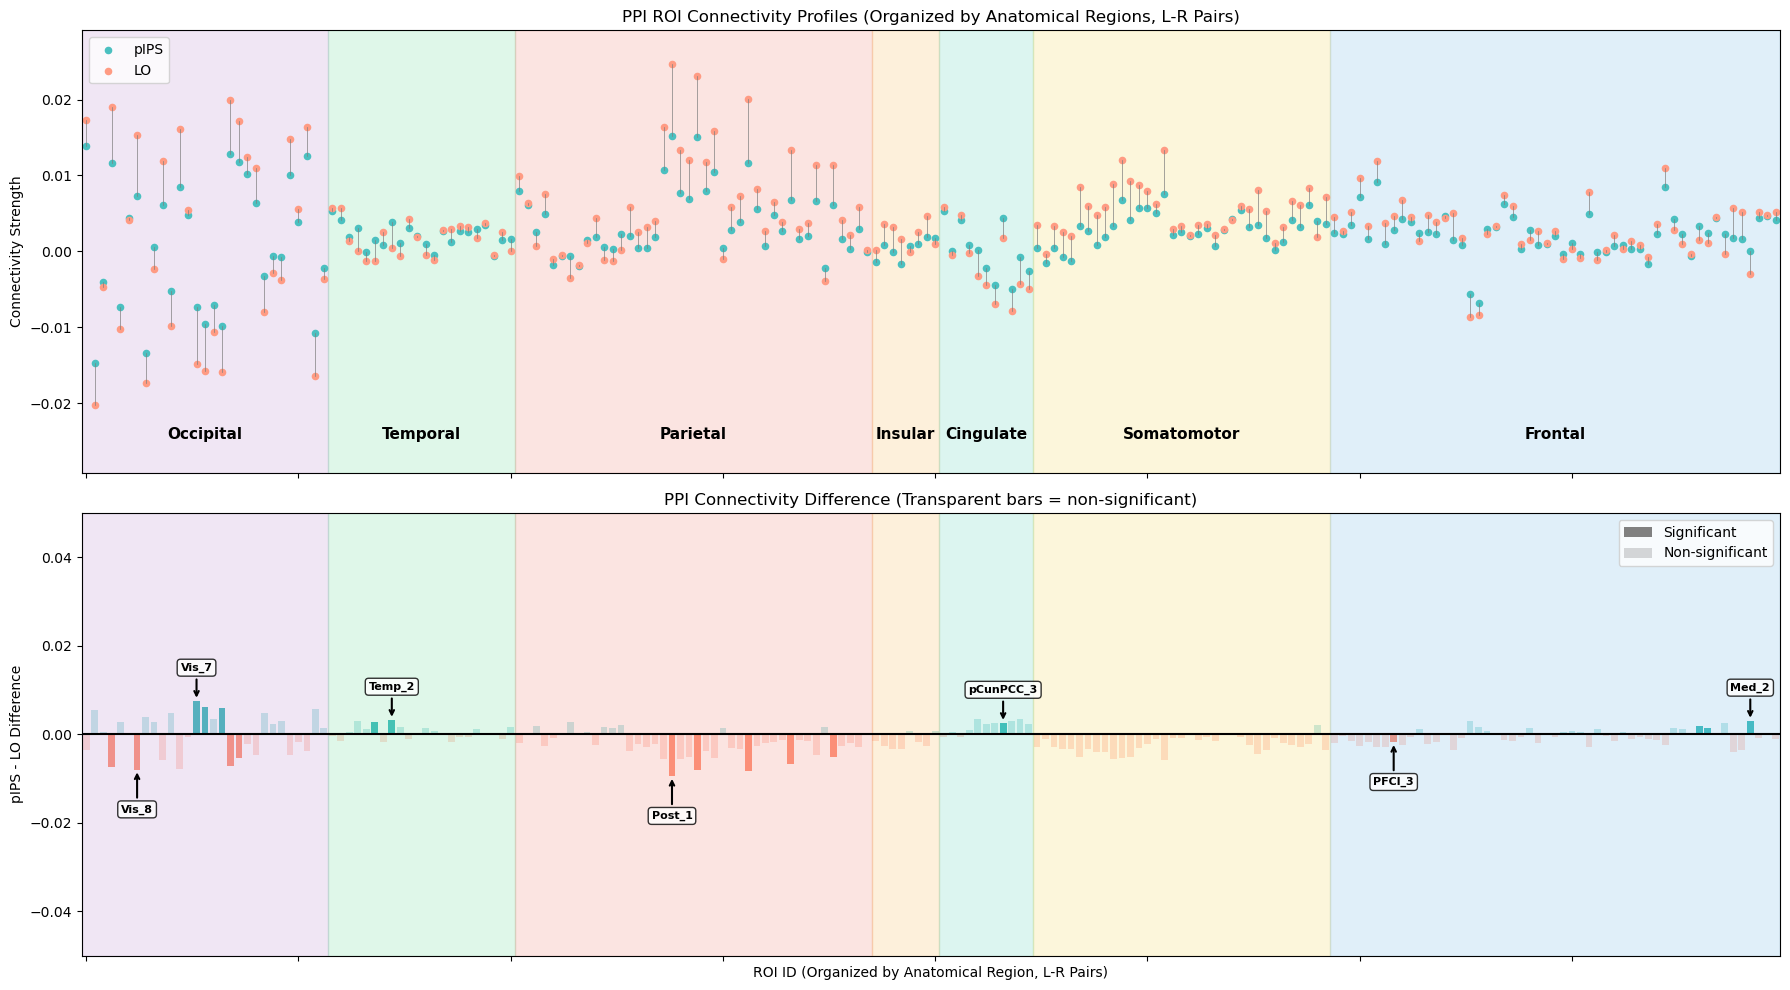

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_comparison/ppi_anatomical_organization.png

PPI significant peak and bottom ROIs by anatomical lobe:

Occipital Lobe:
  Peak (pIPS > LO): Vis_7, Diff = 0.008
  Bottom (LO > pIPS): Vis_8, Diff = -0.008

Temporal Lobe:
  Peak (pIPS > LO): Temp_2, Diff = 0.003
  No significant LO-preferring ROIs in this lobe

Parietal Lobe:
  No significant pIPS-preferring ROIs in this lobe
  Bottom (LO > pIPS): Post_1, Diff = -0.009

Cingulate Lobe:
  Peak (pIPS > LO): pCunPCC_3, Diff = 0.003
  No significant LO-preferring ROIs in this lobe

Frontal Lobe:
  Peak (pIPS > LO): Med_2, Diff = 0.003
  Bottom (LO > pIPS): PFCl_3, Diff = -0.002


In [31]:
# Cell 7: Create PPI Visualization
# Load and visualize PPI data
ppi_results, ppi_data = load_data_for_visualization('ppi')
if ppi_results is not None and ppi_data is not None:
    visualize_anatomical_organization(ppi_results, ppi_data, analysis_type='ppi')